# Numerisk øving

In [230]:
import numpy as np
import matplotlib.pyplot as plt
import time

## Utilities

### Box

In [231]:
class Box:
    def __init__(self, d: float, axis_number_of_points: int, capacitor_height: float = 1) -> None:
        axis = np.linspace(-1, 1, axis_number_of_points)
        self.unit_density = int(axis_number_of_points/2)
        self.grid = np.meshgrid(axis, axis)
        self.x_grid, self.y_grid = self.grid
        self.d = d

        self.capacitor_x_coors = (
            int((1-d/2)*self.unit_density),
            int((1+d/2)*self.unit_density),
        )
        self.capacitor_y_coors = (
            int((1-capacitor_height/2)*self.unit_density),
            int((1+capacitor_height/2)*self.unit_density),
        )
        self.potential = np.zeros_like(self.x_grid)

    def __str__(self) -> str:
        return str(self.potential)
    
    def coor_to_index(self, coor: tuple[float, float]) -> tuple[int, int]:
        return int((1-coor[0])*self.unit_density), int((1-coor[1])*self.unit_density)
    

### Initial conditions

In [232]:
def set_initial_values(new_potential: np.ndarray, box: Box) -> None:
    new_potential[box.capacitor_y_coors[0]:box.capacitor_y_coors[1], box.capacitor_x_coors[0]] = 1
    new_potential[box.capacitor_y_coors[0]:box.capacitor_y_coors[1], box.capacitor_x_coors[1]] = -1
    new_potential[0, :] = new_potential[-1, :] = new_potential[:, 0] = new_potential[:, -1] = 0

### Jacobi

In [233]:
def Jacobi_step(box: Box) -> float:
    old_potential = box.potential
    new_potential = np.zeros_like(old_potential)
    new_potential[1:-1,1:-1] = 1/4*(
        old_potential[0:-2,1:-1]
        + old_potential[2:,1:-1]
        + old_potential[1:-1, 0:-2]
        + old_potential[1:-1, 2:]
    )
    set_initial_values(new_potential, box)
    diff = np.linalg.norm(new_potential - old_potential)
    box.potential = new_potential
    return diff

In [234]:
def Jacobi(box: Box, tolerance: float) -> tuple[Box, int, float]:
    start_time = time.time()
    set_initial_values(box.potential, box)
    i = 0
    diff = tolerance + 10
    while diff > tolerance:
        diff = Jacobi_step(box)
        i += 1

    tot_time = time.time() - start_time
    return box, i, tot_time

### Run the solver on the problem

In [235]:
def run_simulation(d: float, point_density: int, tolerance: float, print_results: bool = True) -> Box:
    box = Box(d, point_density)

    box, iterations, time = Jacobi(box, tolerance)
    if print_results:
        print(f"Time: {time: .3f}sek")
        print(f"Iterations: {iterations: .3f}")
    return box

### Plotting

In [236]:
def plot_data(x_array: np.ndarray, y_array: np.ndarray, label: str, xlabel: str, ylabel: str, title: str) -> None:
    plt.plot(x_array, y_array, label=label)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [264]:
def plot_heat_map(scalar_field: np.ndarray, xlabel: str, ylabel: str, plot_name: str):
    plt.imshow(scalar_field, cmap="RdBu")
    plt.colorbar()
    plt.title(plot_name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(f"Plots/{plot_name}.png") 

In [238]:
def get_length(x_components: np.ndarray, y_components: np.ndarray) -> np.ndarray:
    length = np.sqrt(y_components**2 + x_components**2)
    length[np.round(length, 7) == 0] = 1
    return length

In [265]:
def plot_vector_field(
        vector_field: np.ndarray,
        grid: np.ndarray,
        xlabel: str,
        ylabel: str,
        plot_name: str,
        skip_interval: int = 7
    ) -> None:
    arrow_scale = 2
    skip = (slice(None, None, skip_interval), slice(None, None, skip_interval))
    X = grid[0]
    Y = grid[1]
    U = vector_field[1]
    V = vector_field[0]
    length = get_length(U, V)
    color = np.log10(length)
    # color = np.tanh(length)
    norm_U = arrow_scale*U / length
    norm_V = arrow_scale*V / length
    plt.quiver(X[skip], Y[skip], norm_U[skip], norm_V[skip], color[skip])
    plt.title(plot_name)
    plt.colorbar()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(f"Plots/{plot_name}.png") 

## Oppg. a

Time:  0.878sek
Iterations:  1947.000


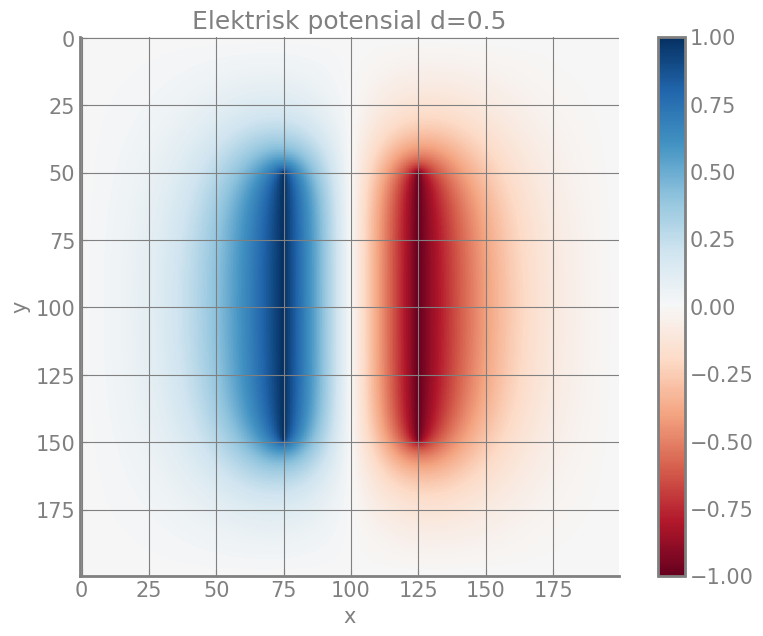

In [267]:
box = run_simulation(0.5, 200, 0.01)
plot_heat_map(box.potential, "x", "y", "Elektrisk potensial d=0.5")

## Oppg. b

Time:  0.927sek
Iterations:  1947.000


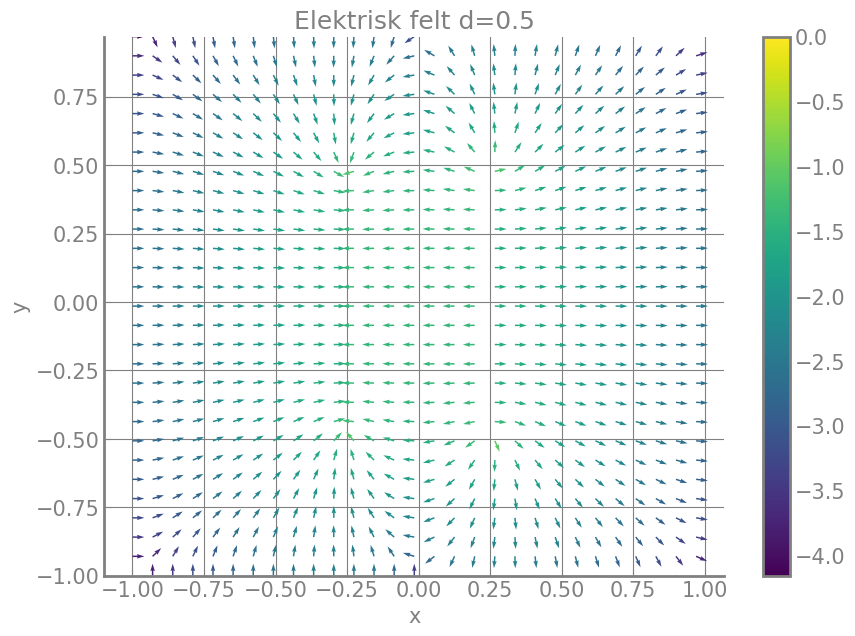

In [269]:
box = run_simulation(0.5, 200, 0.01)
electric_field = np.gradient(box.potential)
plot_vector_field(electric_field, box.grid, "x", "y", "Elektrisk felt d=0.5")

## Oppg. c

In [249]:
def inspect_point(d: float) -> float:
    box = run_simulation(d, 200, 0.01, print_results=False)
    electric_field = np.gradient(box.potential)
    point_to_inspect = (0, 0.6)
    x_index, y_index = box.coor_to_index(point_to_inspect)
    E_x = electric_field[1][y_index, x_index]
    E_y = electric_field[0][y_index, x_index]
    return np.sqrt(E_x**2 + E_y**2)

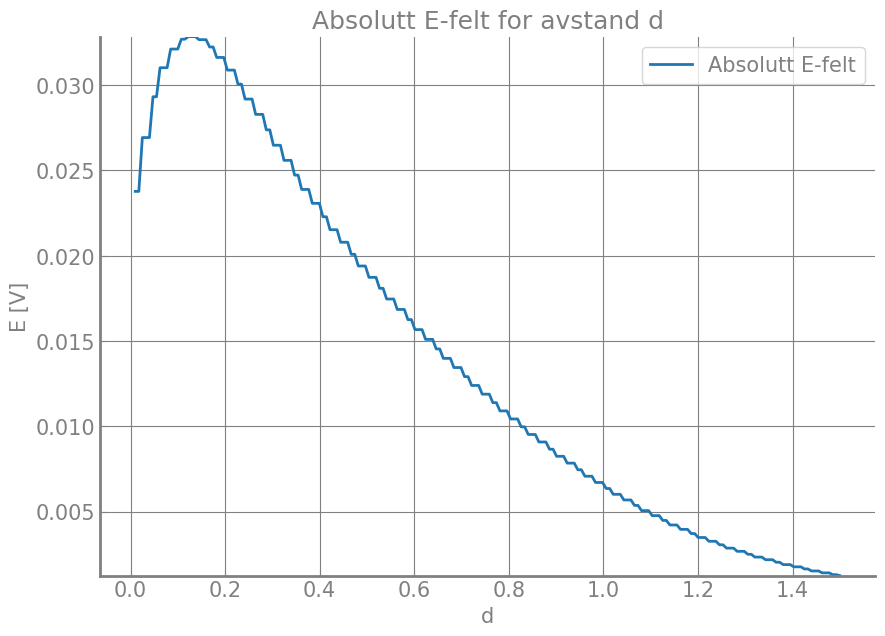

In [270]:
d_array = np.linspace(0.01, 1.5, 200)
E_array = np.zeros_like(d_array)

for i, d in enumerate(d_array):
    E_array[i] = inspect_point(d)

plot_data(
    d_array,
    E_array,
    "Absolutt E-felt",
    "d",
    "E [V]",
    "Absolutt E-felt for avstand d"
)

Det er ganske hakkete på grunn av oppløsingen; her 100 punkter per enhet.